In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N16_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 25
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 16


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/Jackpot/experiments/measure_3D/N16_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 640_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 7.7346508502960205 sec.


  0%|                                                                                                  | 0/800 [00:00<?, ?it/s]

  2%|██                                                                                       | 18/800 [00:03<02:27,  5.32it/s]

 12%|██████████▉                                                                              | 98/800 [00:06<00:43, 16.13it/s]

 15%|████████████▉                                                                           | 118/800 [00:06<00:33, 20.43it/s]

 22%|███████████████████▌                                                                    | 178/800 [00:10<00:32, 19.19it/s]

 25%|█████████████████████▊                                                                  | 198/800 [00:10<00:26, 23.09it/s]

 32%|████████████████████████████▍                                                           | 258/800 [00:13<00:26, 20.47it/s]

 35%|██████████████████████████████▌                                                         | 278/800 [00:13<00:21, 24.16it/s]

 41%|████████████████████████████████████                                                    | 328/800 [00:13<00:12, 38.12it/s]

 45%|███████████████████████████████████████▍                                                | 358/800 [00:17<00:21, 21.00it/s]

 52%|█████████████████████████████████████████████▉                                          | 418/800 [00:20<00:19, 19.92it/s]

 55%|████████████████████████████████████████████████▏                                       | 438/800 [00:20<00:15, 23.28it/s]

 57%|██████████████████████████████████████████████████▍                                     | 458/800 [00:20<00:12, 27.71it/s]

 62%|██████████████████████████████████████████████████████▊                                 | 498/800 [00:23<00:15, 19.50it/s]

 65%|████████████████████████████████████████████████████████▉                               | 518/800 [00:24<00:11, 23.56it/s]

 67%|███████████████████████████████████████████████████████████▏                            | 538/800 [00:24<00:08, 29.24it/s]

 71%|██████████████████████████████████████████████████████████████▍                         | 568/800 [00:24<00:05, 41.19it/s]

 74%|████████████████████████████████████████████████████████████████▋                       | 588/800 [00:27<00:11, 17.88it/s]

 76%|██████████████████████████████████████████████████████████████████▉                     | 608/800 [00:27<00:08, 22.95it/s]

 81%|███████████████████████████████████████████████████████████████████████▎                | 648/800 [00:27<00:04, 37.35it/s]

 84%|█████████████████████████████████████████████████████████████████████████▍              | 668/800 [00:30<00:07, 17.47it/s]

 86%|███████████████████████████████████████████████████████████████████████████▋            | 688/800 [00:31<00:05, 22.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████        | 728/800 [00:31<00:01, 36.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████     | 755/800 [00:31<00:00, 46.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████ | 791/800 [00:31<00:00, 66.12it/s]

Ran thermalisation program in: 34.74718642234802 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 6.668511838154814 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

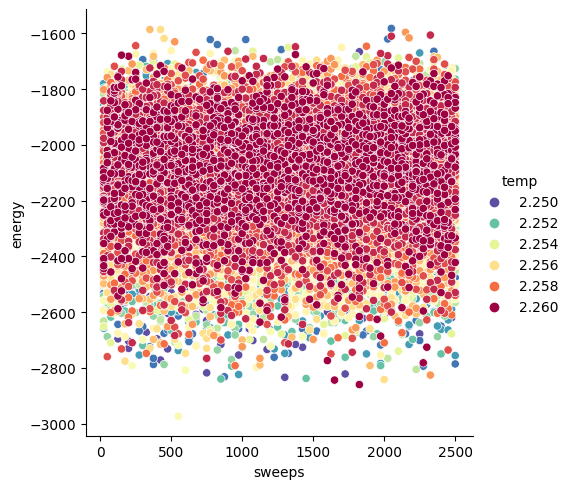

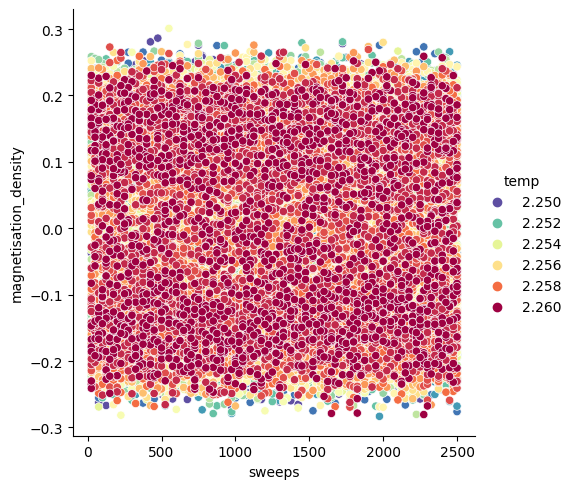

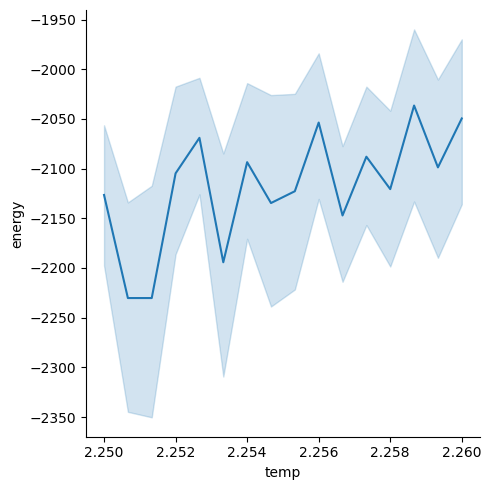

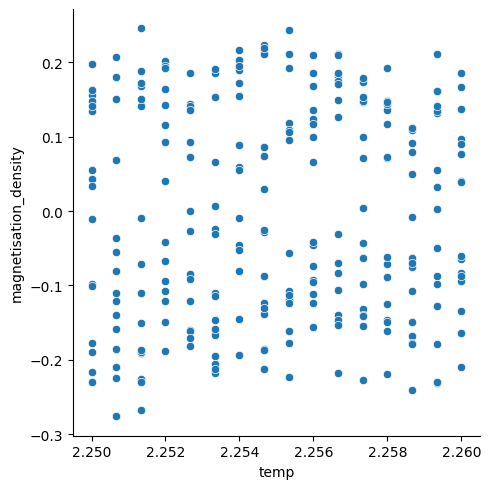

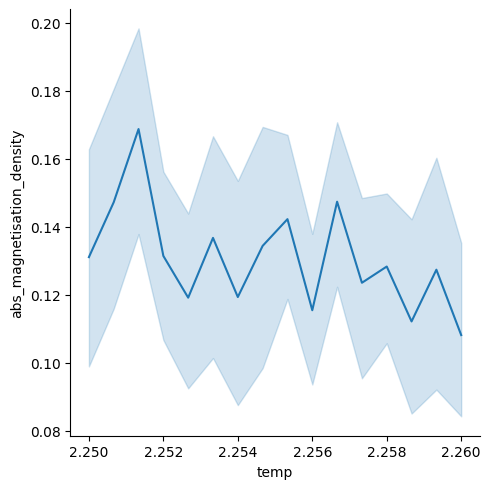

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

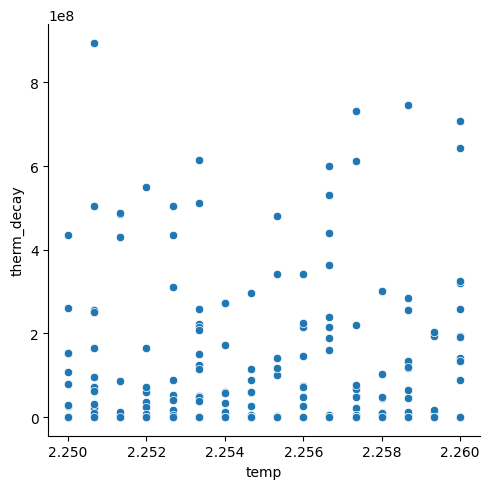

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        250,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


100%|████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 66.12it/s]

  0%|                                                                                                 | 0/8000 [00:00<?, ?it/s]

  0%|▏                                                                                       | 12/8000 [00:00<06:00, 22.14it/s]

  1%|▍                                                                                       | 44/8000 [00:01<03:01, 43.94it/s]

  1%|▊                                                                                       | 76/8000 [00:01<02:35, 50.82it/s]

  1%|█▏                                                                                     | 104/8000 [00:01<01:45, 75.11it/s]

  2%|█▎                                                                                     | 120/8000 [00:02<02:16, 57.75it/s]

  2%|█▌                                                                                     | 140/8000 [00:02<02:38, 49.57it/s]

  2%|█▊                                                                                     | 168/8000 [00:02<01:54, 68.43it/s]

  2%|█▉                                                                                     | 180/8000 [00:03<02:24, 54.12it/s]

  2%|██▏                                                                                    | 200/8000 [00:03<01:54, 68.11it/s]

  3%|██▎                                                                                    | 212/8000 [00:03<02:29, 52.05it/s]

  3%|██▌                                                                                    | 232/8000 [00:03<01:53, 68.69it/s]

  3%|██▋                                                                                    | 244/8000 [00:04<02:32, 50.96it/s]

  3%|██▊                                                                                    | 264/8000 [00:04<01:54, 67.46it/s]

  3%|███                                                                                    | 276/8000 [00:04<02:32, 50.79it/s]

  4%|███▏                                                                                   | 296/8000 [00:05<01:55, 66.94it/s]

  4%|███▎                                                                                   | 308/8000 [00:05<02:32, 50.47it/s]

  4%|███▌                                                                                   | 328/8000 [00:05<01:54, 66.95it/s]

  4%|███▋                                                                                   | 340/8000 [00:06<02:32, 50.18it/s]

  4%|███▉                                                                                   | 360/8000 [00:06<01:55, 65.87it/s]

  5%|████                                                                                   | 372/8000 [00:06<02:32, 49.93it/s]

  5%|████▎                                                                                  | 392/8000 [00:06<01:53, 67.25it/s]

  5%|████▍                                                                                  | 404/8000 [00:07<02:31, 50.09it/s]

  5%|████▌                                                                                  | 424/8000 [00:07<01:53, 66.98it/s]

  5%|████▋                                                                                  | 436/8000 [00:07<02:29, 50.54it/s]

  6%|████▉                                                                                  | 452/8000 [00:07<01:59, 63.31it/s]

  6%|█████                                                                                  | 464/8000 [00:08<02:39, 47.31it/s]

  6%|█████▎                                                                                 | 484/8000 [00:08<01:55, 65.00it/s]

  6%|█████▍                                                                                 | 496/8000 [00:08<02:33, 49.01it/s]

  6%|█████▌                                                                                 | 516/8000 [00:08<01:56, 64.00it/s]

  7%|█████▋                                                                                 | 528/8000 [00:09<02:28, 50.33it/s]

  7%|█████▉                                                                                 | 548/8000 [00:09<01:55, 64.62it/s]

  7%|██████                                                                                 | 560/8000 [00:09<02:25, 50.96it/s]

  7%|██████▎                                                                                | 580/8000 [00:10<01:54, 64.80it/s]

  7%|██████▍                                                                                | 592/8000 [00:10<02:28, 50.03it/s]

  8%|██████▋                                                                                | 612/8000 [00:10<01:55, 63.81it/s]

  8%|██████▊                                                                                | 624/8000 [00:11<02:25, 50.73it/s]

  8%|███████                                                                                | 644/8000 [00:11<01:51, 65.84it/s]

  8%|███████▏                                                                               | 656/8000 [00:11<02:25, 50.38it/s]

  8%|███████▎                                                                               | 676/8000 [00:11<01:50, 66.09it/s]

  9%|███████▍                                                                               | 688/8000 [00:12<02:25, 50.12it/s]

  9%|███████▋                                                                               | 708/8000 [00:12<01:50, 66.24it/s]

  9%|███████▊                                                                               | 720/8000 [00:12<02:24, 50.40it/s]

  9%|████████                                                                               | 740/8000 [00:12<01:50, 65.61it/s]

  9%|████████▏                                                                              | 752/8000 [00:13<02:23, 50.58it/s]

 10%|████████▍                                                                              | 772/8000 [00:13<01:51, 64.56it/s]

 10%|████████▌                                                                              | 784/8000 [00:13<02:22, 50.79it/s]

 10%|████████▋                                                                              | 804/8000 [00:14<01:49, 65.71it/s]

 10%|████████▊                                                                              | 816/8000 [00:14<02:22, 50.41it/s]

 10%|█████████                                                                              | 836/8000 [00:14<01:48, 66.00it/s]

 11%|█████████▏                                                                             | 848/8000 [00:14<02:22, 50.23it/s]

 11%|█████████▍                                                                             | 868/8000 [00:15<01:49, 64.94it/s]

 11%|█████████▌                                                                             | 880/8000 [00:15<02:19, 50.94it/s]

 11%|█████████▊                                                                             | 900/8000 [00:15<01:50, 64.31it/s]

 11%|█████████▉                                                                             | 912/8000 [00:16<02:19, 50.95it/s]

 12%|██████████▏                                                                            | 932/8000 [00:16<01:51, 63.16it/s]

 12%|██████████▎                                                                            | 944/8000 [00:16<02:16, 51.58it/s]

 12%|██████████▍                                                                            | 964/8000 [00:16<01:50, 63.77it/s]

 12%|██████████▌                                                                            | 976/8000 [00:17<02:16, 51.34it/s]

 12%|██████████▊                                                                            | 996/8000 [00:17<01:49, 64.09it/s]

 13%|██████████▊                                                                           | 1008/8000 [00:17<02:13, 52.24it/s]

 13%|███████████                                                                           | 1024/8000 [00:17<01:47, 65.04it/s]

 13%|███████████▏                                                                          | 1036/8000 [00:18<02:19, 49.87it/s]

 13%|███████████▎                                                                          | 1048/8000 [00:18<01:58, 58.85it/s]

 13%|███████████▍                                                                          | 1060/8000 [00:18<01:48, 63.90it/s]

 13%|███████████▌                                                                          | 1072/8000 [00:18<02:15, 51.06it/s]

 14%|███████████▋                                                                          | 1088/8000 [00:18<01:43, 66.74it/s]

 14%|███████████▊                                                                          | 1100/8000 [00:19<02:17, 50.36it/s]

 14%|███████████▉                                                                          | 1108/8000 [00:19<02:08, 53.55it/s]

 14%|████████████                                                                          | 1124/8000 [00:19<01:45, 65.04it/s]

 14%|████████████▏                                                                         | 1136/8000 [00:20<02:17, 50.07it/s]

 14%|████████████▍                                                                         | 1156/8000 [00:20<01:47, 63.79it/s]

 15%|████████████▌                                                                         | 1164/8000 [00:20<02:10, 52.20it/s]

 15%|████████████▋                                                                         | 1180/8000 [00:20<01:46, 64.27it/s]

 15%|████████████▊                                                                         | 1188/8000 [00:20<01:50, 61.59it/s]

 15%|████████████▊                                                                         | 1196/8000 [00:21<02:16, 49.82it/s]

 15%|█████████████                                                                         | 1212/8000 [00:21<01:47, 63.43it/s]

 15%|█████████████                                                                         | 1220/8000 [00:21<01:48, 62.54it/s]

 15%|█████████████▏                                                                        | 1228/8000 [00:21<02:19, 48.68it/s]

 16%|█████████████▎                                                                        | 1244/8000 [00:21<01:45, 64.04it/s]

 16%|█████████████▍                                                                        | 1252/8000 [00:21<01:47, 62.61it/s]

 16%|█████████████▌                                                                        | 1260/8000 [00:22<02:13, 50.57it/s]

 16%|█████████████▋                                                                        | 1268/8000 [00:22<02:05, 53.48it/s]

 16%|█████████████▊                                                                        | 1284/8000 [00:22<01:45, 63.50it/s]

 16%|█████████████▉                                                                        | 1292/8000 [00:22<02:08, 52.13it/s]

 16%|█████████████▉                                                                        | 1300/8000 [00:22<02:04, 53.96it/s]

 16%|██████████████▏                                                                       | 1316/8000 [00:22<01:40, 66.68it/s]

 17%|██████████████▏                                                                       | 1324/8000 [00:23<02:04, 53.79it/s]

 17%|██████████████▎                                                                       | 1332/8000 [00:23<02:03, 53.92it/s]

 17%|██████████████▍                                                                       | 1348/8000 [00:23<01:41, 65.39it/s]

 17%|██████████████▌                                                                       | 1356/8000 [00:23<02:01, 54.46it/s]

 17%|██████████████▋                                                                       | 1364/8000 [00:23<02:03, 53.74it/s]

 17%|██████████████▊                                                                       | 1380/8000 [00:24<01:43, 63.97it/s]

 17%|██████████████▉                                                                       | 1388/8000 [00:24<02:03, 53.58it/s]

 17%|███████████████                                                                       | 1396/8000 [00:24<01:55, 57.00it/s]

 18%|███████████████▏                                                                      | 1412/8000 [00:24<01:44, 62.88it/s]

 18%|███████████████▎                                                                      | 1420/8000 [00:24<02:03, 53.29it/s]

 18%|███████████████▍                                                                      | 1432/8000 [00:25<01:53, 57.80it/s]

 18%|███████████████▌                                                                      | 1444/8000 [00:25<01:43, 63.25it/s]

 18%|███████████████▌                                                                      | 1452/8000 [00:25<01:58, 55.27it/s]

 18%|███████████████▋                                                                      | 1460/8000 [00:25<01:52, 58.19it/s]

 18%|███████████████▊                                                                      | 1472/8000 [00:25<01:32, 70.43it/s]

 18%|███████████████▉                                                                      | 1480/8000 [00:25<01:51, 58.42it/s]

 19%|███████████████▉                                                                      | 1488/8000 [00:26<02:01, 53.76it/s]

 19%|████████████████                                                                      | 1496/8000 [00:26<01:54, 56.92it/s]

 19%|████████████████▏                                                                     | 1508/8000 [00:26<01:48, 59.80it/s]

 19%|████████████████▎                                                                     | 1516/8000 [00:26<02:00, 53.78it/s]

 19%|████████████████▍                                                                     | 1524/8000 [00:26<01:54, 56.71it/s]

 19%|████████████████▌                                                                     | 1536/8000 [00:26<01:35, 67.97it/s]

 19%|████████████████▌                                                                     | 1544/8000 [00:26<01:57, 54.85it/s]

 19%|████████████████▋                                                                     | 1552/8000 [00:27<01:52, 57.10it/s]

 20%|████████████████▊                                                                     | 1560/8000 [00:27<02:01, 53.13it/s]

 20%|████████████████▉                                                                     | 1572/8000 [00:27<01:52, 57.17it/s]

 20%|████████████████▉                                                                     | 1580/8000 [00:27<01:59, 53.84it/s]

 20%|█████████████████                                                                     | 1588/8000 [00:27<01:51, 57.71it/s]

 20%|█████████████████▏                                                                    | 1604/8000 [00:28<01:47, 59.48it/s]

 20%|█████████████████▎                                                                    | 1612/8000 [00:28<01:55, 55.12it/s]

 20%|█████████████████▍                                                                    | 1620/8000 [00:28<01:50, 57.81it/s]

 20%|█████████████████▌                                                                    | 1636/8000 [00:28<01:46, 59.93it/s]

 21%|█████████████████▋                                                                    | 1644/8000 [00:28<01:51, 56.93it/s]

 21%|█████████████████▊                                                                    | 1652/8000 [00:28<01:47, 58.86it/s]

 21%|█████████████████▉                                                                    | 1664/8000 [00:28<01:30, 70.40it/s]

 21%|█████████████████▉                                                                    | 1672/8000 [00:29<02:00, 52.37it/s]

 21%|██████████████████                                                                    | 1684/8000 [00:29<01:50, 57.20it/s]

 21%|██████████████████▏                                                                   | 1692/8000 [00:29<01:43, 61.04it/s]

 21%|██████████████████▎                                                                   | 1700/8000 [00:29<01:48, 58.32it/s]

 21%|██████████████████▎                                                                   | 1708/8000 [00:29<01:47, 58.34it/s]

 21%|██████████████████▍                                                                   | 1716/8000 [00:29<01:52, 56.03it/s]

 22%|██████████████████▌                                                                   | 1724/8000 [00:30<01:43, 60.71it/s]

 22%|██████████████████▌                                                                   | 1732/8000 [00:30<01:48, 57.92it/s]

 22%|██████████████████▋                                                                   | 1740/8000 [00:30<01:50, 56.87it/s]

 22%|██████████████████▊                                                                   | 1748/8000 [00:30<01:50, 56.39it/s]

 22%|██████████████████▉                                                                   | 1756/8000 [00:30<01:43, 60.44it/s]

 22%|██████████████████▉                                                                   | 1764/8000 [00:30<01:46, 58.34it/s]

 22%|███████████████████                                                                   | 1772/8000 [00:30<01:49, 57.04it/s]

 22%|███████████████████▏                                                                  | 1780/8000 [00:31<01:48, 57.12it/s]

 22%|███████████████████▏                                                                  | 1788/8000 [00:31<01:45, 58.98it/s]

 22%|███████████████████▎                                                                  | 1796/8000 [00:31<01:48, 57.09it/s]

 23%|███████████████████▍                                                                  | 1804/8000 [00:31<01:46, 58.42it/s]

 23%|███████████████████▍                                                                  | 1812/8000 [00:31<01:44, 58.97it/s]

 23%|███████████████████▌                                                                  | 1820/8000 [00:31<01:48, 56.81it/s]

 23%|███████████████████▋                                                                  | 1828/8000 [00:31<01:49, 56.46it/s]

 23%|███████████████████▋                                                                  | 1836/8000 [00:32<01:44, 58.83it/s]

 23%|███████████████████▊                                                                  | 1844/8000 [00:32<01:42, 60.08it/s]

 23%|███████████████████▉                                                                  | 1852/8000 [00:32<01:51, 55.13it/s]

 23%|███████████████████▉                                                                  | 1860/8000 [00:32<01:49, 55.91it/s]

 23%|████████████████████                                                                  | 1868/8000 [00:32<01:44, 58.60it/s]

 23%|████████████████████▏                                                                 | 1876/8000 [00:32<01:47, 56.93it/s]

 24%|████████████████████▎                                                                 | 1884/8000 [00:32<01:45, 57.81it/s]

 24%|████████████████████▎                                                                 | 1892/8000 [00:33<01:54, 53.42it/s]

 24%|████████████████████▍                                                                 | 1900/8000 [00:33<01:44, 58.24it/s]

 24%|████████████████████▌                                                                 | 1908/8000 [00:33<01:42, 59.19it/s]

 24%|████████████████████▌                                                                 | 1916/8000 [00:33<01:46, 57.39it/s]

 24%|████████████████████▋                                                                 | 1924/8000 [00:33<01:56, 52.24it/s]

 24%|████████████████████▊                                                                 | 1932/8000 [00:33<01:46, 57.01it/s]

 24%|████████████████████▊                                                                 | 1940/8000 [00:33<01:38, 61.52it/s]

 24%|████████████████████▉                                                                 | 1948/8000 [00:33<01:47, 56.46it/s]

 24%|█████████████████████                                                                 | 1956/8000 [00:34<01:57, 51.48it/s]

 25%|█████████████████████                                                                 | 1964/8000 [00:34<01:49, 55.14it/s]

 25%|█████████████████████▏                                                                | 1976/8000 [00:34<01:46, 56.70it/s]

 25%|█████████████████████▎                                                                | 1988/8000 [00:34<01:52, 53.47it/s]

 25%|█████████████████████▌                                                                | 2000/8000 [00:34<01:40, 59.65it/s]

 25%|█████████████████████▌                                                                | 2008/8000 [00:35<01:44, 57.16it/s]

 25%|█████████████████████▋                                                                | 2020/8000 [00:35<01:53, 52.69it/s]

 25%|█████████████████████▊                                                                | 2032/8000 [00:35<01:36, 61.57it/s]

 26%|█████████████████████▉                                                                | 2040/8000 [00:35<01:45, 56.64it/s]

 26%|██████████████████████                                                                | 2052/8000 [00:35<01:53, 52.36it/s]

 26%|██████████████████████▏                                                               | 2068/8000 [00:36<01:29, 66.48it/s]

 26%|██████████████████████▎                                                               | 2076/8000 [00:36<01:41, 58.21it/s]

 26%|██████████████████████▍                                                               | 2084/8000 [00:36<01:57, 50.31it/s]

 26%|██████████████████████▌                                                               | 2100/8000 [00:36<01:29, 65.74it/s]

 26%|██████████████████████▋                                                               | 2108/8000 [00:36<01:43, 56.94it/s]

 26%|██████████████████████▋                                                               | 2116/8000 [00:37<01:55, 50.75it/s]

 27%|██████████████████████▉                                                               | 2132/8000 [00:37<01:28, 66.19it/s]

 27%|███████████████████████                                                               | 2140/8000 [00:37<01:44, 56.20it/s]

 27%|███████████████████████                                                               | 2148/8000 [00:37<01:56, 50.41it/s]

 27%|███████████████████████▎                                                              | 2164/8000 [00:37<01:27, 66.85it/s]

 27%|███████████████████████▎                                                              | 2172/8000 [00:37<01:41, 57.31it/s]

 27%|███████████████████████▍                                                              | 2180/8000 [00:38<01:53, 51.24it/s]

 27%|███████████████████████▌                                                              | 2192/8000 [00:38<01:31, 63.49it/s]

 28%|███████████████████████▋                                                              | 2200/8000 [00:38<01:52, 51.67it/s]

 28%|███████████████████████▊                                                              | 2212/8000 [00:38<01:46, 54.27it/s]

 28%|███████████████████████▊                                                              | 2220/8000 [00:38<01:39, 58.15it/s]

 28%|███████████████████████▉                                                              | 2232/8000 [00:39<01:45, 54.52it/s]

 28%|████████████████████████                                                              | 2244/8000 [00:39<01:40, 57.39it/s]

 28%|████████████████████████▏                                                             | 2252/8000 [00:39<01:36, 59.66it/s]

 28%|████████████████████████▎                                                             | 2264/8000 [00:39<01:43, 55.50it/s]

 28%|████████████████████████▍                                                             | 2276/8000 [00:39<01:40, 56.73it/s]

 29%|████████████████████████▌                                                             | 2284/8000 [00:39<01:35, 60.06it/s]

 29%|████████████████████████▋                                                             | 2296/8000 [00:40<01:39, 57.07it/s]

 29%|████████████████████████▊                                                             | 2308/8000 [00:40<01:38, 57.97it/s]

 29%|████████████████████████▉                                                             | 2316/8000 [00:40<01:33, 60.69it/s]

 29%|█████████████████████████                                                             | 2328/8000 [00:40<01:40, 56.31it/s]

 29%|█████████████████████████▏                                                            | 2340/8000 [00:40<01:40, 56.36it/s]

 29%|█████████████████████████▏                                                            | 2348/8000 [00:40<01:35, 59.23it/s]

 30%|█████████████████████████▎                                                            | 2360/8000 [00:41<01:36, 58.35it/s]

 30%|█████████████████████████▍                                                            | 2372/8000 [00:41<01:42, 55.02it/s]

 30%|█████████████████████████▋                                                            | 2384/8000 [00:41<01:27, 63.88it/s]

 30%|█████████████████████████▋                                                            | 2392/8000 [00:41<01:36, 57.92it/s]

 30%|█████████████████████████▊                                                            | 2404/8000 [00:42<01:45, 52.87it/s]

 30%|█████████████████████████▉                                                            | 2416/8000 [00:42<01:29, 62.65it/s]

 30%|██████████████████████████                                                            | 2424/8000 [00:42<01:37, 56.93it/s]

 30%|██████████████████████████▏                                                           | 2436/8000 [00:42<01:45, 52.56it/s]

 31%|██████████████████████████▎                                                           | 2448/8000 [00:42<01:26, 63.91it/s]

 31%|██████████████████████████▍                                                           | 2456/8000 [00:42<01:38, 56.44it/s]

 31%|██████████████████████████▌                                                           | 2468/8000 [00:43<01:47, 51.38it/s]

 31%|██████████████████████████▋                                                           | 2484/8000 [00:43<01:19, 69.47it/s]

 31%|██████████████████████████▊                                                           | 2496/8000 [00:43<01:29, 61.81it/s]

 31%|██████████████████████████▉                                                           | 2504/8000 [00:43<01:42, 53.63it/s]

 32%|███████████████████████████                                                           | 2520/8000 [00:43<01:40, 54.61it/s]

 32%|███████████████████████████▏                                                          | 2532/8000 [00:44<01:45, 51.95it/s]

 32%|███████████████████████████▍                                                          | 2548/8000 [00:44<01:20, 68.08it/s]

 32%|███████████████████████████▌                                                          | 2560/8000 [00:44<01:33, 58.20it/s]

 32%|███████████████████████████▌                                                          | 2568/8000 [00:44<01:38, 54.88it/s]

 32%|███████████████████████████▊                                                          | 2584/8000 [00:45<01:39, 54.49it/s]

 32%|███████████████████████████▉                                                          | 2596/8000 [00:45<01:37, 55.20it/s]

 33%|████████████████████████████                                                          | 2612/8000 [00:45<01:20, 66.57it/s]

 33%|████████████████████████████▏                                                         | 2620/8000 [00:45<01:32, 58.21it/s]

 33%|████████████████████████████▎                                                         | 2628/8000 [00:45<01:36, 55.65it/s]

 33%|████████████████████████████▎                                                         | 2636/8000 [00:45<01:32, 58.26it/s]

 33%|████████████████████████████▍                                                         | 2648/8000 [00:46<01:42, 52.17it/s]

 33%|████████████████████████████▌                                                         | 2660/8000 [00:46<01:32, 58.02it/s]

 33%|████████████████████████████▋                                                         | 2668/8000 [00:46<01:29, 59.80it/s]

 34%|████████████████████████████▊                                                         | 2680/8000 [00:46<01:40, 53.19it/s]

 34%|████████████████████████████▉                                                         | 2692/8000 [00:46<01:32, 57.39it/s]

 34%|█████████████████████████████                                                         | 2700/8000 [00:47<01:30, 58.40it/s]

 34%|█████████████████████████████▏                                                        | 2712/8000 [00:47<01:34, 55.75it/s]

 34%|█████████████████████████████▏                                                        | 2720/8000 [00:47<01:28, 59.90it/s]

 34%|█████████████████████████████▎                                                        | 2728/8000 [00:47<01:30, 58.47it/s]

 34%|█████████████████████████████▍                                                        | 2740/8000 [00:47<01:21, 64.47it/s]

 34%|█████████████████████████████▌                                                        | 2748/8000 [00:47<01:33, 56.29it/s]

 34%|█████████████████████████████▋                                                        | 2756/8000 [00:48<01:29, 58.51it/s]

 35%|█████████████████████████████▋                                                        | 2764/8000 [00:48<01:32, 56.69it/s]

 35%|█████████████████████████████▊                                                        | 2772/8000 [00:48<01:25, 61.06it/s]

 35%|█████████████████████████████▉                                                        | 2780/8000 [00:48<01:37, 53.65it/s]

 35%|██████████████████████████████                                                        | 2792/8000 [00:48<01:35, 54.51it/s]

 35%|██████████████████████████████▏                                                       | 2804/8000 [00:48<01:24, 61.36it/s]

 35%|██████████████████████████████▏                                                       | 2812/8000 [00:49<01:32, 55.89it/s]

 35%|██████████████████████████████▎                                                       | 2824/8000 [00:49<01:34, 54.58it/s]

 35%|██████████████████████████████▍                                                       | 2836/8000 [00:49<01:24, 61.04it/s]

 36%|██████████████████████████████▌                                                       | 2844/8000 [00:49<01:31, 56.51it/s]

 36%|██████████████████████████████▋                                                       | 2856/8000 [00:49<01:35, 54.09it/s]

 36%|██████████████████████████████▊                                                       | 2868/8000 [00:49<01:22, 62.21it/s]

 36%|██████████████████████████████▉                                                       | 2876/8000 [00:50<01:29, 57.50it/s]

 36%|███████████████████████████████                                                       | 2888/8000 [00:50<01:31, 55.67it/s]

 36%|███████████████████████████████▏                                                      | 2900/8000 [00:50<01:25, 59.48it/s]

 36%|███████████████████████████████▎                                                      | 2908/8000 [00:50<01:28, 57.66it/s]

 36%|███████████████████████████████▎                                                      | 2916/8000 [00:50<01:24, 60.17it/s]

 37%|███████████████████████████████▍                                                      | 2924/8000 [00:50<01:30, 56.28it/s]

 37%|███████████████████████████████▌                                                      | 2932/8000 [00:51<01:25, 59.33it/s]

 37%|███████████████████████████████▌                                                      | 2940/8000 [00:51<01:27, 57.92it/s]

 37%|███████████████████████████████▋                                                      | 2948/8000 [00:51<01:26, 58.42it/s]

 37%|███████████████████████████████▊                                                      | 2956/8000 [00:51<01:30, 55.55it/s]

 37%|███████████████████████████████▊                                                      | 2964/8000 [00:51<01:26, 58.48it/s]

 37%|███████████████████████████████▉                                                      | 2972/8000 [00:51<01:29, 56.09it/s]

 37%|████████████████████████████████                                                      | 2980/8000 [00:51<01:26, 58.18it/s]

 37%|████████████████████████████████                                                      | 2988/8000 [00:52<01:30, 55.45it/s]

 37%|████████████████████████████████▏                                                     | 2996/8000 [00:52<01:29, 56.13it/s]

 38%|████████████████████████████████▎                                                     | 3004/8000 [00:52<01:27, 57.18it/s]

 38%|████████████████████████████████▍                                                     | 3012/8000 [00:52<01:21, 61.34it/s]

 38%|████████████████████████████████▍                                                     | 3020/8000 [00:52<01:29, 55.83it/s]

 38%|████████████████████████████████▌                                                     | 3028/8000 [00:52<01:28, 55.95it/s]

 38%|████████████████████████████████▋                                                     | 3036/8000 [00:52<01:26, 57.57it/s]

 38%|████████████████████████████████▋                                                     | 3044/8000 [00:53<01:22, 60.38it/s]

 38%|████████████████████████████████▊                                                     | 3052/8000 [00:53<01:27, 56.35it/s]

 38%|████████████████████████████████▉                                                     | 3060/8000 [00:53<01:32, 53.43it/s]

 38%|████████████████████████████████▉                                                     | 3068/8000 [00:53<01:24, 58.20it/s]

 38%|█████████████████████████████████                                                     | 3076/8000 [00:53<01:20, 61.21it/s]

 39%|█████████████████████████████████▏                                                    | 3084/8000 [00:53<01:25, 57.27it/s]

 39%|█████████████████████████████████▏                                                    | 3092/8000 [00:53<01:31, 53.75it/s]

 39%|█████████████████████████████████▎                                                    | 3100/8000 [00:54<01:23, 58.43it/s]

 39%|█████████████████████████████████▍                                                    | 3108/8000 [00:54<01:22, 59.06it/s]

 39%|█████████████████████████████████▍                                                    | 3116/8000 [00:54<01:24, 57.92it/s]

 39%|█████████████████████████████████▌                                                    | 3124/8000 [00:54<01:35, 51.07it/s]

 39%|█████████████████████████████████▋                                                    | 3136/8000 [00:54<01:27, 55.41it/s]

 39%|█████████████████████████████████▊                                                    | 3148/8000 [00:54<01:16, 63.58it/s]

 39%|█████████████████████████████████▉                                                    | 3156/8000 [00:55<01:32, 52.46it/s]

 40%|██████████████████████████████████                                                    | 3168/8000 [00:55<01:25, 56.40it/s]

 40%|██████████████████████████████████▏                                                   | 3180/8000 [00:55<01:15, 63.85it/s]

 40%|██████████████████████████████████▎                                                   | 3188/8000 [00:55<01:32, 51.85it/s]

 40%|██████████████████████████████████▍                                                   | 3200/8000 [00:55<01:25, 56.23it/s]

 40%|██████████████████████████████████▌                                                   | 3212/8000 [00:55<01:11, 66.78it/s]

 40%|██████████████████████████████████▌                                                   | 3220/8000 [00:56<01:33, 51.07it/s]

 40%|██████████████████████████████████▋                                                   | 3232/8000 [00:56<01:24, 56.75it/s]

 41%|██████████████████████████████████▊                                                   | 3244/8000 [00:56<01:12, 65.99it/s]

 41%|██████████████████████████████████▉                                                   | 3252/8000 [00:56<01:32, 51.44it/s]

 41%|███████████████████████████████████                                                   | 3264/8000 [00:56<01:22, 57.25it/s]

 41%|███████████████████████████████████▏                                                  | 3276/8000 [00:57<01:09, 67.76it/s]

 41%|███████████████████████████████████▎                                                  | 3284/8000 [00:57<01:30, 52.12it/s]

 41%|███████████████████████████████████▍                                                  | 3296/8000 [00:57<01:24, 55.69it/s]

 41%|███████████████████████████████████▌                                                  | 3312/8000 [00:57<01:16, 60.92it/s]

 42%|███████████████████████████████████▋                                                  | 3320/8000 [00:57<01:21, 57.30it/s]

 42%|███████████████████████████████████▊                                                  | 3328/8000 [00:58<01:23, 55.85it/s]

 42%|███████████████████████████████████▉                                                  | 3340/8000 [00:58<01:09, 66.88it/s]

 42%|███████████████████████████████████▉                                                  | 3348/8000 [00:58<01:33, 49.83it/s]

 42%|████████████████████████████████████                                                  | 3360/8000 [00:58<01:23, 55.25it/s]

 42%|████████████████████████████████████▎                                                 | 3376/8000 [00:58<01:13, 62.51it/s]

 42%|████████████████████████████████████▍                                                 | 3384/8000 [00:59<01:21, 56.36it/s]

 42%|████████████████████████████████████▍                                                 | 3392/8000 [00:59<01:26, 53.51it/s]

 43%|████████████████████████████████████▋                                                 | 3408/8000 [00:59<01:13, 62.83it/s]

 43%|████████████████████████████████████▋                                                 | 3416/8000 [00:59<01:22, 55.55it/s]

 43%|████████████████████████████████████▊                                                 | 3424/8000 [00:59<01:23, 54.55it/s]

 43%|████████████████████████████████████▉                                                 | 3440/8000 [00:59<01:13, 62.41it/s]

 43%|█████████████████████████████████████                                                 | 3448/8000 [01:00<01:27, 51.85it/s]

 43%|█████████████████████████████████████▏                                                | 3456/8000 [01:00<01:22, 55.10it/s]

 43%|█████████████████████████████████████▎                                                | 3472/8000 [01:00<01:12, 62.48it/s]

 44%|█████████████████████████████████████▍                                                | 3480/8000 [01:00<01:23, 54.27it/s]

 44%|█████████████████████████████████████▍                                                | 3488/8000 [01:00<01:20, 55.89it/s]

 44%|█████████████████████████████████████▋                                                | 3504/8000 [01:01<01:11, 62.50it/s]

 44%|█████████████████████████████████████▊                                                | 3512/8000 [01:01<01:21, 55.39it/s]

 44%|█████████████████████████████████████▊                                                | 3520/8000 [01:01<01:19, 56.65it/s]

 44%|██████████████████████████████████████                                                | 3536/8000 [01:01<01:11, 62.47it/s]

 44%|██████████████████████████████████████                                                | 3544/8000 [01:01<01:22, 54.08it/s]

 44%|██████████████████████████████████████▏                                               | 3552/8000 [01:01<01:18, 56.53it/s]

 45%|██████████████████████████████████████▎                                               | 3568/8000 [01:02<01:13, 60.40it/s]

 45%|██████████████████████████████████████▍                                               | 3576/8000 [01:02<01:22, 53.31it/s]

 45%|██████████████████████████████████████▌                                               | 3588/8000 [01:02<01:12, 60.90it/s]

 45%|██████████████████████████████████████▋                                               | 3600/8000 [01:02<01:14, 58.72it/s]

 45%|██████████████████████████████████████▊                                               | 3608/8000 [01:02<01:21, 53.73it/s]

 45%|██████████████████████████████████████▉                                               | 3620/8000 [01:03<01:12, 60.45it/s]

 45%|███████████████████████████████████████                                               | 3632/8000 [01:03<01:14, 58.55it/s]

 46%|███████████████████████████████████████▏                                              | 3640/8000 [01:03<01:22, 52.66it/s]

 46%|███████████████████████████████████████▎                                              | 3652/8000 [01:03<01:13, 59.26it/s]

 46%|███████████████████████████████████████▍                                              | 3664/8000 [01:03<01:16, 56.99it/s]

 46%|███████████████████████████████████████▍                                              | 3672/8000 [01:04<01:18, 54.96it/s]

 46%|███████████████████████████████████████▌                                              | 3684/8000 [01:04<01:12, 59.36it/s]

 46%|███████████████████████████████████████▋                                              | 3696/8000 [01:04<01:18, 54.96it/s]

 46%|███████████████████████████████████████▊                                              | 3704/8000 [01:04<01:17, 55.21it/s]

 46%|███████████████████████████████████████▉                                              | 3716/8000 [01:04<01:11, 59.73it/s]

 47%|████████████████████████████████████████                                              | 3728/8000 [01:05<01:17, 55.34it/s]

 47%|████████████████████████████████████████▏                                             | 3736/8000 [01:05<01:14, 57.41it/s]

 47%|████████████████████████████████████████▎                                             | 3748/8000 [01:05<01:09, 60.75it/s]

 47%|████████████████████████████████████████▍                                             | 3760/8000 [01:05<01:16, 55.24it/s]

 47%|████████████████████████████████████████▌                                             | 3768/8000 [01:05<01:15, 56.08it/s]

 47%|████████████████████████████████████████▌                                             | 3776/8000 [01:05<01:11, 59.28it/s]

 47%|████████████████████████████████████████▊                                             | 3792/8000 [01:06<01:16, 55.23it/s]

 48%|████████████████████████████████████████▊                                             | 3800/8000 [01:06<01:13, 57.51it/s]

 48%|████████████████████████████████████████▉                                             | 3808/8000 [01:06<01:11, 58.69it/s]

 48%|█████████████████████████████████████████                                             | 3824/8000 [01:06<01:16, 54.29it/s]

 48%|█████████████████████████████████████████▏                                            | 3832/8000 [01:06<01:12, 57.46it/s]

 48%|█████████████████████████████████████████▎                                            | 3840/8000 [01:06<01:10, 59.05it/s]

 48%|█████████████████████████████████████████▍                                            | 3856/8000 [01:07<01:18, 52.51it/s]

 48%|█████████████████████████████████████████▌                                            | 3868/8000 [01:07<01:10, 58.53it/s]

 48%|█████████████████████████████████████████▋                                            | 3880/8000 [01:07<01:00, 68.62it/s]

 49%|█████████████████████████████████████████▊                                            | 3888/8000 [01:07<01:20, 51.14it/s]

 49%|█████████████████████████████████████████▉                                            | 3900/8000 [01:08<01:09, 58.79it/s]

 49%|██████████████████████████████████████████                                            | 3912/8000 [01:08<01:01, 65.94it/s]

 49%|██████████████████████████████████████████▏                                           | 3920/8000 [01:08<01:22, 49.18it/s]

 49%|██████████████████████████████████████████▎                                           | 3932/8000 [01:08<01:08, 59.11it/s]

 49%|██████████████████████████████████████████▍                                           | 3944/8000 [01:08<01:02, 65.29it/s]

 49%|██████████████████████████████████████████▍                                           | 3952/8000 [01:08<01:22, 49.33it/s]

 50%|██████████████████████████████████████████▌                                           | 3964/8000 [01:09<01:08, 58.55it/s]

 50%|██████████████████████████████████████████▋                                           | 3976/8000 [01:09<01:01, 65.18it/s]

 50%|██████████████████████████████████████████▊                                           | 3984/8000 [01:09<01:21, 49.51it/s]

 50%|██████████████████████████████████████████▉                                           | 3996/8000 [01:09<01:06, 59.83it/s]

 50%|███████████████████████████████████████████                                           | 4004/8000 [01:09<01:03, 63.01it/s]

 50%|███████████████████████████████████████████▏                                          | 4016/8000 [01:10<01:17, 51.11it/s]

 50%|███████████████████████████████████████████▎                                          | 4028/8000 [01:10<01:05, 60.86it/s]

 50%|███████████████████████████████████████████▍                                          | 4036/8000 [01:10<01:02, 63.93it/s]

 51%|███████████████████████████████████████████▌                                          | 4048/8000 [01:10<01:15, 52.33it/s]

 51%|███████████████████████████████████████████▌                                          | 4056/8000 [01:10<01:11, 55.36it/s]

 51%|███████████████████████████████████████████▋                                          | 4068/8000 [01:10<01:01, 64.37it/s]

 51%|███████████████████████████████████████████▊                                          | 4080/8000 [01:11<01:16, 51.27it/s]

 51%|███████████████████████████████████████████▉                                          | 4088/8000 [01:11<01:10, 55.60it/s]

 51%|████████████████████████████████████████████                                          | 4100/8000 [01:11<01:00, 64.76it/s]

 51%|████████████████████████████████████████████▏                                         | 4112/8000 [01:11<01:14, 52.16it/s]

 52%|████████████████████████████████████████████▎                                         | 4120/8000 [01:11<01:08, 56.57it/s]

 52%|████████████████████████████████████████████▍                                         | 4132/8000 [01:11<00:58, 65.95it/s]

 52%|████████████████████████████████████████████▌                                         | 4144/8000 [01:12<01:13, 52.19it/s]

 52%|████████████████████████████████████████████▋                                         | 4156/8000 [01:12<01:00, 63.13it/s]

 52%|████████████████████████████████████████████▊                                         | 4164/8000 [01:12<01:01, 62.43it/s]

 52%|████████████████████████████████████████████▉                                         | 4176/8000 [01:12<01:13, 51.83it/s]

 52%|█████████████████████████████████████████████                                         | 4188/8000 [01:12<01:01, 61.73it/s]

 52%|█████████████████████████████████████████████                                         | 4196/8000 [01:13<01:02, 60.38it/s]

 53%|█████████████████████████████████████████████▏                                        | 4208/8000 [01:13<01:14, 50.75it/s]

 53%|█████████████████████████████████████████████▎                                        | 4220/8000 [01:13<01:01, 61.50it/s]

 53%|█████████████████████████████████████████████▍                                        | 4228/8000 [01:13<01:03, 59.13it/s]

 53%|█████████████████████████████████████████████▌                                        | 4240/8000 [01:14<01:15, 49.83it/s]

 53%|█████████████████████████████████████████████▊                                        | 4256/8000 [01:14<00:59, 63.05it/s]

 53%|█████████████████████████████████████████████▊                                        | 4264/8000 [01:14<00:58, 63.76it/s]

 53%|█████████████████████████████████████████████▉                                        | 4272/8000 [01:14<01:17, 48.33it/s]

 54%|██████████████████████████████████████████████                                        | 4288/8000 [01:14<01:01, 60.45it/s]

 54%|██████████████████████████████████████████████▏                                       | 4300/8000 [01:14<00:52, 70.71it/s]

 54%|██████████████████████████████████████████████▎                                       | 4312/8000 [01:15<01:08, 53.69it/s]

 54%|██████████████████████████████████████████████▍                                       | 4320/8000 [01:15<01:05, 56.50it/s]

 54%|██████████████████████████████████████████████▌                                       | 4332/8000 [01:15<00:55, 65.53it/s]

 54%|██████████████████████████████████████████████▋                                       | 4340/8000 [01:15<01:17, 47.36it/s]

 54%|██████████████████████████████████████████████▊                                       | 4352/8000 [01:15<01:02, 58.39it/s]

 55%|██████████████████████████████████████████████▉                                       | 4364/8000 [01:16<00:55, 65.12it/s]

 55%|██████████████████████████████████████████████▉                                       | 4372/8000 [01:16<01:15, 47.98it/s]

 55%|███████████████████████████████████████████████▏                                      | 4392/8000 [01:16<00:50, 70.83it/s]

 55%|███████████████████████████████████████████████▎                                      | 4404/8000 [01:16<01:11, 49.98it/s]

 55%|███████████████████████████████████████████████▍                                      | 4416/8000 [01:16<00:59, 59.99it/s]

 55%|███████████████████████████████████████████████▌                                      | 4428/8000 [01:17<00:56, 63.46it/s]

 56%|███████████████████████████████████████████████▋                                      | 4440/8000 [01:17<01:04, 54.83it/s]

 56%|███████████████████████████████████████████████▊                                      | 4448/8000 [01:17<01:00, 58.35it/s]

 56%|███████████████████████████████████████████████▉                                      | 4460/8000 [01:17<00:56, 63.09it/s]

 56%|████████████████████████████████████████████████                                      | 4468/8000 [01:17<01:13, 48.28it/s]

 56%|████████████████████████████████████████████████▏                                     | 4480/8000 [01:18<00:59, 59.32it/s]

 56%|████████████████████████████████████████████████▎                                     | 4492/8000 [01:18<00:54, 64.62it/s]

 56%|████████████████████████████████████████████████▍                                     | 4500/8000 [01:18<01:12, 48.01it/s]

 56%|████████████████████████████████████████████████▌                                     | 4516/8000 [01:18<00:54, 64.24it/s]

 57%|████████████████████████████████████████████████▋                                     | 4528/8000 [01:19<01:12, 47.72it/s]

 57%|████████████████████████████████████████████████▊                                     | 4544/8000 [01:19<00:55, 62.16it/s]

 57%|████████████████████████████████████████████████▉                                     | 4556/8000 [01:19<00:55, 62.07it/s]

 57%|█████████████████████████████████████████████████                                     | 4564/8000 [01:19<01:05, 52.58it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4576/8000 [01:19<00:55, 61.57it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4588/8000 [01:19<00:55, 61.35it/s]

 57%|█████████████████████████████████████████████████▍                                    | 4596/8000 [01:20<01:07, 50.52it/s]

 58%|█████████████████████████████████████████████████▌                                    | 4612/8000 [01:20<00:53, 63.91it/s]

 58%|█████████████████████████████████████████████████▋                                    | 4620/8000 [01:20<00:57, 59.22it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4628/8000 [01:20<01:06, 50.93it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4644/8000 [01:20<00:51, 65.69it/s]

 58%|██████████████████████████████████████████████████                                    | 4652/8000 [01:21<00:55, 60.05it/s]

 58%|██████████████████████████████████████████████████                                    | 4660/8000 [01:21<01:06, 50.42it/s]

 58%|██████████████████████████████████████████████████▎                                   | 4676/8000 [01:21<00:50, 66.33it/s]

 59%|██████████████████████████████████████████████████▎                                   | 4684/8000 [01:21<00:57, 57.44it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4692/8000 [01:21<01:05, 50.62it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4708/8000 [01:21<00:51, 64.25it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4716/8000 [01:22<00:55, 58.95it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4724/8000 [01:22<01:05, 49.83it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4740/8000 [01:22<00:51, 63.59it/s]

 59%|███████████████████████████████████████████████████                                   | 4748/8000 [01:22<00:53, 60.78it/s]

 59%|███████████████████████████████████████████████████▏                                  | 4756/8000 [01:22<01:04, 49.95it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4772/8000 [01:23<00:51, 63.26it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4780/8000 [01:23<00:52, 60.93it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4788/8000 [01:23<01:03, 50.89it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4800/8000 [01:23<00:51, 61.67it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4808/8000 [01:23<00:50, 63.10it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4816/8000 [01:24<01:06, 48.02it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4828/8000 [01:24<00:56, 56.13it/s]

 60%|████████████████████████████████████████████████████                                  | 4840/8000 [01:24<00:51, 61.95it/s]

 61%|████████████████████████████████████████████████████                                  | 4848/8000 [01:24<01:02, 50.64it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4856/8000 [01:24<00:56, 55.37it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4872/8000 [01:24<00:51, 60.77it/s]

 61%|████████████████████████████████████████████████████▍                                 | 4880/8000 [01:25<00:58, 53.36it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4888/8000 [01:25<00:54, 56.80it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4904/8000 [01:25<00:50, 61.81it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4912/8000 [01:25<00:57, 53.73it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4920/8000 [01:25<00:54, 56.43it/s]

 62%|█████████████████████████████████████████████████████                                 | 4936/8000 [01:25<00:49, 61.86it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4944/8000 [01:26<00:57, 52.89it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4956/8000 [01:26<00:52, 58.33it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4968/8000 [01:26<00:50, 59.60it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4976/8000 [01:26<00:56, 53.76it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4988/8000 [01:26<00:51, 58.19it/s]

 62%|█████████████████████████████████████████████████████▊                                | 5000/8000 [01:27<00:48, 61.43it/s]

 63%|█████████████████████████████████████████████████████▊                                | 5008/8000 [01:27<00:57, 52.21it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5020/8000 [01:27<00:50, 59.41it/s]

 63%|██████████████████████████████████████████████████████                                | 5032/8000 [01:27<00:48, 61.61it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5040/8000 [01:27<00:56, 52.49it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5052/8000 [01:28<00:49, 59.70it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5064/8000 [01:28<00:47, 61.60it/s]

 63%|██████████████████████████████████████████████████████▌                               | 5072/8000 [01:28<00:56, 51.87it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5084/8000 [01:28<00:47, 61.55it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5096/8000 [01:28<00:47, 60.65it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5104/8000 [01:29<00:55, 51.75it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5116/8000 [01:29<00:48, 60.00it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5128/8000 [01:29<00:46, 61.74it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5136/8000 [01:29<00:55, 51.82it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5148/8000 [01:29<00:48, 58.82it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5160/8000 [01:29<00:45, 63.05it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5168/8000 [01:30<00:54, 51.61it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5180/8000 [01:30<00:48, 57.99it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5192/8000 [01:30<00:46, 60.42it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5200/8000 [01:30<00:51, 53.97it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5208/8000 [01:30<00:51, 53.95it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5224/8000 [01:31<00:44, 61.83it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5232/8000 [01:31<00:50, 54.87it/s]

 66%|████████████████████████████████████████████████████████▎                             | 5240/8000 [01:31<00:52, 52.66it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5256/8000 [01:31<00:42, 64.18it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5264/8000 [01:31<00:48, 55.87it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5272/8000 [01:31<00:50, 53.79it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5284/8000 [01:32<00:41, 66.20it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5292/8000 [01:32<00:41, 65.46it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5300/8000 [01:32<00:51, 52.68it/s]

 66%|█████████████████████████████████████████████████████████                             | 5308/8000 [01:32<00:46, 57.63it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 5320/8000 [01:32<00:43, 61.23it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5328/8000 [01:32<00:51, 51.80it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5336/8000 [01:33<00:51, 51.80it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5348/8000 [01:33<00:41, 63.74it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5356/8000 [01:33<00:42, 61.89it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5364/8000 [01:33<00:50, 51.94it/s]

 67%|█████████████████████████████████████████████████████████▊                            | 5376/8000 [01:33<00:41, 63.42it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5384/8000 [01:33<00:43, 60.10it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5392/8000 [01:33<00:48, 53.85it/s]

 68%|██████████████████████████████████████████████████████████                            | 5400/8000 [01:34<00:51, 50.49it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5412/8000 [01:34<00:40, 63.68it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5420/8000 [01:34<00:40, 63.45it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5428/8000 [01:34<00:50, 50.46it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5436/8000 [01:34<00:46, 55.23it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5448/8000 [01:34<00:40, 63.33it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5456/8000 [01:35<00:46, 55.19it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5464/8000 [01:35<00:48, 52.02it/s]

 68%|██████████████████████████████████████████████████████████▉                           | 5480/8000 [01:35<00:41, 61.02it/s]

 69%|██████████████████████████████████████████████████████████▉                           | 5488/8000 [01:35<00:43, 57.31it/s]

 69%|███████████████████████████████████████████████████████████                           | 5496/8000 [01:35<00:47, 52.26it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5512/8000 [01:36<00:39, 62.72it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5520/8000 [01:36<00:43, 57.08it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5528/8000 [01:36<00:46, 52.98it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5544/8000 [01:36<00:39, 62.08it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5552/8000 [01:36<00:43, 55.76it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5560/8000 [01:36<00:44, 54.32it/s]

 70%|███████████████████████████████████████████████████████████▉                          | 5576/8000 [01:37<00:38, 62.80it/s]

 70%|████████████████████████████████████████████████████████████                          | 5584/8000 [01:37<00:43, 55.68it/s]

 70%|████████████████████████████████████████████████████████████                          | 5592/8000 [01:37<00:43, 54.81it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5608/8000 [01:37<00:37, 63.55it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5616/8000 [01:37<00:42, 55.75it/s]

 70%|████████████████████████████████████████████████████████████▍                         | 5624/8000 [01:38<00:44, 53.87it/s]

 70%|████████████████████████████████████████████████████████████▋                         | 5640/8000 [01:38<00:38, 62.09it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 5648/8000 [01:38<00:42, 55.97it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5656/8000 [01:38<00:43, 54.30it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5668/8000 [01:38<00:34, 66.80it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5676/8000 [01:38<00:42, 54.10it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5684/8000 [01:39<00:43, 53.06it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5692/8000 [01:39<00:41, 55.47it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5704/8000 [01:39<00:37, 61.23it/s]

 71%|█████████████████████████████████████████████████████████████▍                        | 5712/8000 [01:39<00:40, 57.05it/s]

 72%|█████████████████████████████████████████████████████████████▍                        | 5720/8000 [01:39<00:42, 53.69it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5736/8000 [01:39<00:38, 58.25it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5744/8000 [01:40<00:38, 59.33it/s]

 72%|█████████████████████████████████████████████████████████████▊                        | 5752/8000 [01:40<00:40, 55.04it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5764/8000 [01:40<00:33, 66.76it/s]

 72%|██████████████████████████████████████████████████████████████                        | 5772/8000 [01:40<00:41, 53.31it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5780/8000 [01:40<00:41, 53.41it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5788/8000 [01:40<00:37, 58.55it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5800/8000 [01:41<00:37, 57.96it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5808/8000 [01:41<00:36, 60.27it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5816/8000 [01:41<00:38, 56.26it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5824/8000 [01:41<00:36, 59.08it/s]

 73%|██████████████████████████████████████████████████████████████▋                       | 5832/8000 [01:41<00:37, 58.51it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5840/8000 [01:41<00:37, 58.23it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5848/8000 [01:41<00:38, 56.35it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5856/8000 [01:42<00:36, 58.92it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5864/8000 [01:42<00:35, 60.09it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5872/8000 [01:42<00:37, 56.44it/s]

 74%|███████████████████████████████████████████████████████████████▏                      | 5880/8000 [01:42<00:37, 55.86it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5888/8000 [01:42<00:34, 60.63it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5896/8000 [01:42<00:34, 61.39it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5904/8000 [01:42<00:37, 56.29it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5912/8000 [01:43<00:37, 55.69it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5924/8000 [01:43<00:31, 64.95it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5932/8000 [01:43<00:41, 49.96it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5940/8000 [01:43<00:37, 54.66it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5948/8000 [01:43<00:34, 59.49it/s]

 74%|████████████████████████████████████████████████████████████████                      | 5960/8000 [01:43<00:33, 60.13it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5968/8000 [01:43<00:35, 56.84it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5976/8000 [01:44<00:36, 55.70it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5988/8000 [01:44<00:31, 64.32it/s]

 75%|████████████████████████████████████████████████████████████████▍                     | 5996/8000 [01:44<00:38, 51.79it/s]

 75%|████████████████████████████████████████████████████████████████▌                     | 6008/8000 [01:44<00:34, 58.10it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6020/8000 [01:44<00:31, 63.14it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6028/8000 [01:45<00:38, 51.15it/s]

 76%|████████████████████████████████████████████████████████████████▉                     | 6040/8000 [01:45<00:32, 60.08it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6048/8000 [01:45<00:32, 60.22it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6056/8000 [01:45<00:33, 58.81it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6064/8000 [01:45<00:34, 55.76it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6072/8000 [01:45<00:31, 60.60it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6080/8000 [01:45<00:32, 59.77it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6088/8000 [01:46<00:31, 60.07it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 6096/8000 [01:46<00:34, 54.62it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6108/8000 [01:46<00:34, 54.15it/s]

 76%|█████████████████████████████████████████████████████████████████▊                    | 6120/8000 [01:46<00:30, 62.36it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 6128/8000 [01:46<00:34, 54.69it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6140/8000 [01:46<00:33, 54.99it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6152/8000 [01:47<00:29, 61.75it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6160/8000 [01:47<00:33, 55.02it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6172/8000 [01:47<00:33, 54.00it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6184/8000 [01:47<00:28, 62.85it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6192/8000 [01:47<00:32, 55.18it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6204/8000 [01:48<00:31, 56.57it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6216/8000 [01:48<00:28, 61.98it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6224/8000 [01:48<00:32, 53.84it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6236/8000 [01:48<00:32, 54.91it/s]

 78%|███████████████████████████████████████████████████████████████████▏                  | 6248/8000 [01:48<00:26, 65.35it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6256/8000 [01:49<00:33, 52.08it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6268/8000 [01:49<00:31, 55.48it/s]

 78%|███████████████████████████████████████████████████████████████████▌                  | 6280/8000 [01:49<00:25, 67.03it/s]

 79%|███████████████████████████████████████████████████████████████████▌                  | 6288/8000 [01:49<00:33, 51.64it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6300/8000 [01:49<00:30, 56.66it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6308/8000 [01:49<00:28, 59.90it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6316/8000 [01:50<00:31, 52.95it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6324/8000 [01:50<00:28, 58.04it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6332/8000 [01:50<00:29, 57.29it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6344/8000 [01:50<00:24, 67.91it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 6352/8000 [01:50<00:31, 52.39it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6364/8000 [01:50<00:28, 57.90it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6372/8000 [01:50<00:26, 60.68it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 6380/8000 [01:51<00:31, 51.87it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6392/8000 [01:51<00:27, 58.99it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6400/8000 [01:51<00:27, 57.73it/s]

 80%|████████████████████████████████████████████████████████████████████▉                 | 6412/8000 [01:51<00:29, 54.41it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6424/8000 [01:51<00:27, 57.04it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6432/8000 [01:52<00:25, 61.05it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6444/8000 [01:52<00:27, 55.96it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6452/8000 [01:52<00:25, 59.90it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6460/8000 [01:52<00:25, 59.64it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6468/8000 [01:52<00:25, 60.22it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6476/8000 [01:52<00:28, 54.21it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6484/8000 [01:52<00:26, 57.53it/s]

 81%|█████████████████████████████████████████████████████████████████████▊                | 6492/8000 [01:53<00:25, 58.29it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6500/8000 [01:53<00:23, 62.86it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6508/8000 [01:53<00:27, 54.58it/s]

 81%|██████████████████████████████████████████████████████████████████████                | 6516/8000 [01:53<00:25, 58.57it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6524/8000 [01:53<00:25, 58.87it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6532/8000 [01:53<00:23, 61.22it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6540/8000 [01:53<00:27, 53.08it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6548/8000 [01:54<00:24, 58.49it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6556/8000 [01:54<00:24, 58.56it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6564/8000 [01:54<00:23, 60.80it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6572/8000 [01:54<00:26, 53.73it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6580/8000 [01:54<00:24, 58.93it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6588/8000 [01:54<00:24, 58.67it/s]

 82%|██████████████████████████████████████████████████████████████████████▉               | 6596/8000 [01:54<00:24, 57.61it/s]

 83%|██████████████████████████████████████████████████████████████████████▉               | 6604/8000 [01:55<00:25, 55.28it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6612/8000 [01:55<00:23, 58.79it/s]

 83%|███████████████████████████████████████████████████████████████████████▏              | 6620/8000 [01:55<00:22, 61.00it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6628/8000 [01:55<00:23, 57.40it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6636/8000 [01:55<00:24, 56.63it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6644/8000 [01:55<00:24, 56.43it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6652/8000 [01:55<00:23, 58.51it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6660/8000 [01:56<00:23, 57.25it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 6668/8000 [01:56<00:23, 57.19it/s]

 83%|███████████████████████████████████████████████████████████████████████▊              | 6676/8000 [01:56<00:22, 58.10it/s]

 84%|███████████████████████████████████████████████████████████████████████▊              | 6684/8000 [01:56<00:22, 57.51it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6692/8000 [01:56<00:23, 56.36it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6700/8000 [01:56<00:22, 56.81it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6708/8000 [01:56<00:23, 55.95it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6716/8000 [01:56<00:21, 59.16it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6724/8000 [01:57<00:22, 56.97it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6732/8000 [01:57<00:22, 56.07it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6740/8000 [01:57<00:22, 56.02it/s]

 84%|████████████████████████████████████████████████████████████████████████▌             | 6748/8000 [01:57<00:20, 60.79it/s]

 84%|████████████████████████████████████████████████████████████████████████▋             | 6756/8000 [01:57<00:20, 59.57it/s]

 85%|████████████████████████████████████████████████████████████████████████▋             | 6764/8000 [01:57<00:21, 57.12it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6772/8000 [01:57<00:22, 53.92it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6784/8000 [01:58<00:19, 61.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████             | 6792/8000 [01:58<00:21, 56.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████             | 6800/8000 [01:58<00:23, 51.73it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6812/8000 [01:58<00:20, 57.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6820/8000 [01:58<00:19, 59.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6828/8000 [01:58<00:20, 58.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6836/8000 [01:59<00:20, 55.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████▌            | 6844/8000 [01:59<00:20, 57.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6852/8000 [01:59<00:19, 58.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6860/8000 [01:59<00:19, 58.37it/s]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 6868/8000 [01:59<00:21, 53.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████▉            | 6876/8000 [01:59<00:19, 57.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 6884/8000 [01:59<00:19, 57.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 6892/8000 [02:00<00:18, 59.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████▏           | 6900/8000 [02:00<00:19, 57.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6908/8000 [02:00<00:18, 57.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6916/8000 [02:00<00:19, 56.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████▍           | 6928/8000 [02:00<00:18, 57.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6936/8000 [02:00<00:17, 62.23it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6944/8000 [02:00<00:16, 62.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6952/8000 [02:01<00:17, 58.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6960/8000 [02:01<00:18, 55.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████▉           | 6972/8000 [02:01<00:18, 54.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 6980/8000 [02:01<00:19, 53.24it/s]

 87%|███████████████████████████████████████████████████████████████████████████▏          | 6992/8000 [02:01<00:17, 56.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7004/8000 [02:02<00:17, 57.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7012/8000 [02:02<00:17, 55.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7024/8000 [02:02<00:17, 57.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7036/8000 [02:02<00:16, 57.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7044/8000 [02:02<00:16, 57.41it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7056/8000 [02:02<00:16, 55.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7068/8000 [02:03<00:15, 60.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7076/8000 [02:03<00:16, 56.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████▏         | 7088/8000 [02:03<00:16, 56.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7100/8000 [02:03<00:15, 59.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7108/8000 [02:03<00:15, 57.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 7120/8000 [02:04<00:15, 55.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7132/8000 [02:04<00:14, 59.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7140/8000 [02:04<00:14, 58.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████▉         | 7152/8000 [02:04<00:15, 55.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7164/8000 [02:04<00:14, 57.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7172/8000 [02:04<00:14, 56.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 7184/8000 [02:05<00:14, 56.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7196/8000 [02:05<00:14, 55.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7204/8000 [02:05<00:13, 57.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7216/8000 [02:05<00:13, 58.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7228/8000 [02:05<00:14, 54.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 7236/8000 [02:06<00:13, 56.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 7248/8000 [02:06<00:12, 59.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7260/8000 [02:06<00:13, 54.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7268/8000 [02:06<00:13, 55.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7280/8000 [02:06<00:11, 61.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7292/8000 [02:07<00:13, 53.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7300/8000 [02:07<00:12, 56.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7312/8000 [02:07<00:10, 63.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 7324/8000 [02:07<00:12, 53.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7332/8000 [02:07<00:11, 58.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 7344/8000 [02:07<00:10, 62.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7356/8000 [02:08<00:11, 54.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7364/8000 [02:08<00:10, 57.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7372/8000 [02:08<00:10, 62.13it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7384/8000 [02:08<00:08, 69.29it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7392/8000 [02:08<00:11, 55.21it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 7404/8000 [02:08<00:10, 57.63it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7416/8000 [02:09<00:08, 64.95it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7424/8000 [02:09<00:10, 53.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7436/8000 [02:09<00:09, 57.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7448/8000 [02:09<00:08, 63.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7456/8000 [02:09<00:10, 52.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7468/8000 [02:10<00:09, 56.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7480/8000 [02:10<00:07, 65.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7488/8000 [02:10<00:09, 52.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7500/8000 [02:10<00:08, 57.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7512/8000 [02:10<00:07, 63.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7520/8000 [02:11<00:09, 51.40it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7532/8000 [02:11<00:08, 57.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7544/8000 [02:11<00:07, 64.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7552/8000 [02:11<00:08, 50.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▎    | 7564/8000 [02:11<00:07, 59.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7576/8000 [02:11<00:06, 65.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7584/8000 [02:12<00:08, 49.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7596/8000 [02:12<00:06, 58.10it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7608/8000 [02:12<00:05, 66.31it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7616/8000 [02:12<00:07, 49.95it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7628/8000 [02:12<00:06, 57.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7640/8000 [02:12<00:05, 63.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7648/8000 [02:13<00:06, 50.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7660/8000 [02:13<00:05, 57.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7672/8000 [02:13<00:05, 64.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7680/8000 [02:13<00:06, 50.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7692/8000 [02:13<00:05, 59.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7704/8000 [02:14<00:04, 64.08it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7712/8000 [02:14<00:05, 50.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7724/8000 [02:14<00:04, 57.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7736/8000 [02:14<00:04, 64.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7744/8000 [02:14<00:05, 47.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7756/8000 [02:15<00:04, 59.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7768/8000 [02:15<00:03, 68.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▋  | 7780/8000 [02:15<00:04, 52.75it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7792/8000 [02:15<00:03, 63.59it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7804/8000 [02:15<00:03, 52.39it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7812/8000 [02:16<00:03, 53.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7828/8000 [02:16<00:02, 66.89it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7836/8000 [02:16<00:03, 51.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 7844/8000 [02:16<00:02, 54.27it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7860/8000 [02:16<00:02, 64.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7868/8000 [02:17<00:02, 52.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 7876/8000 [02:17<00:02, 54.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7892/8000 [02:17<00:01, 64.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7900/8000 [02:17<00:01, 54.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████ | 7908/8000 [02:17<00:01, 54.90it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 7920/8000 [02:17<00:01, 65.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▎| 7934/8000 [02:18<00:00, 76.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 7945/8000 [02:18<00:00, 55.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▌| 7957/8000 [02:18<00:00, 58.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▌| 7964/8000 [02:18<00:00, 50.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▋| 7971/8000 [02:18<00:00, 48.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▊| 7978/8000 [02:19<00:00, 47.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▊| 7986/8000 [02:19<00:00, 33.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▉| 7993/8000 [02:19<00:00, 29.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████▉| 7997/8000 [02:19<00:00, 26.36it/s]

Ran measurement program in: 149.95157527923584 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

100%|██████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:33<00:00, 26.36it/s]

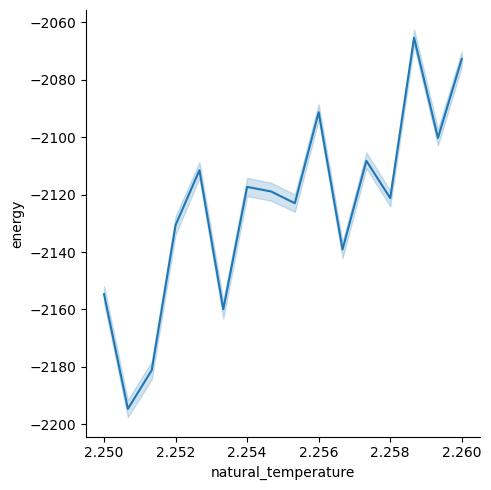

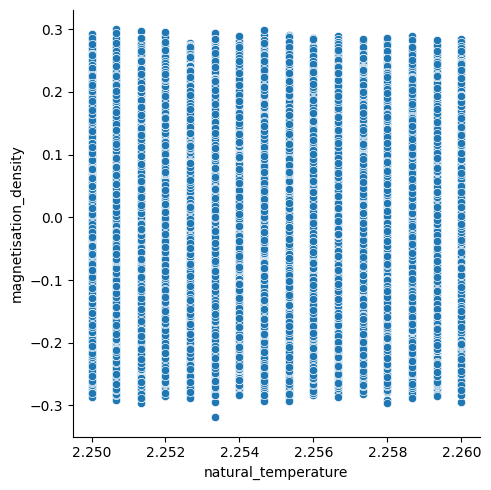

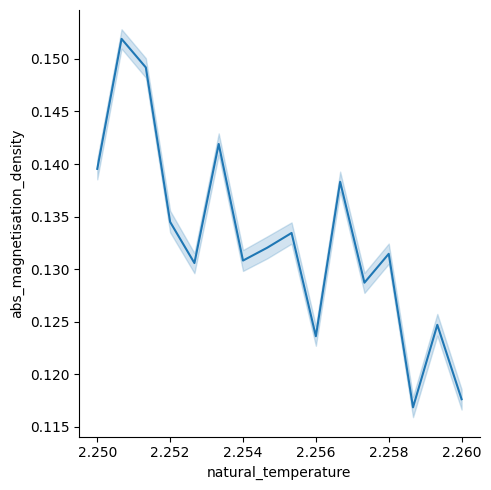

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

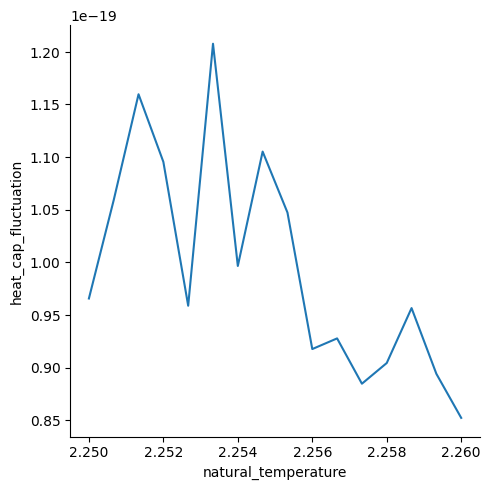

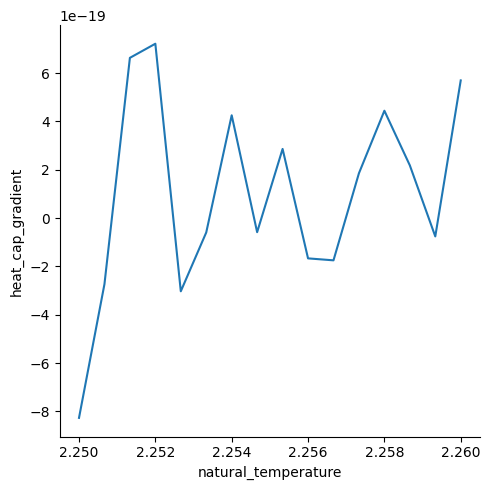

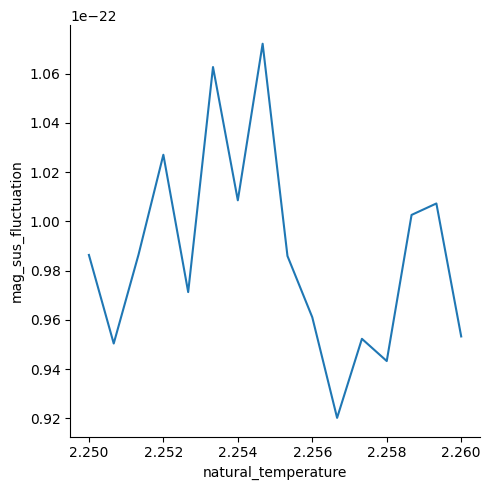

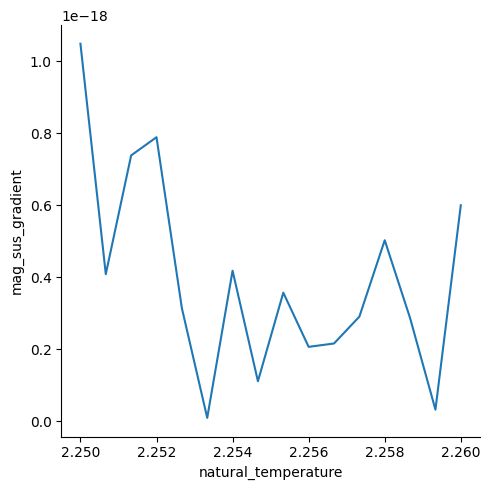

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

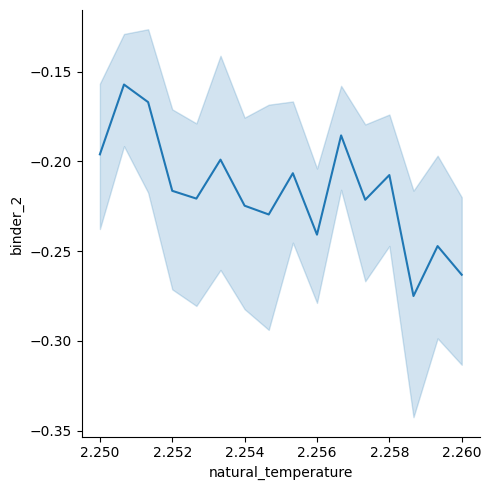

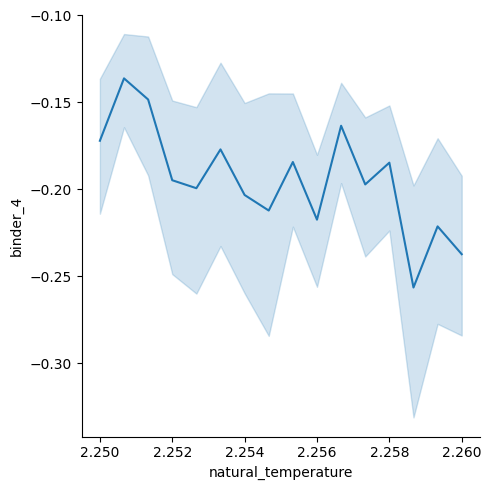

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )